In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, RandomTranslation, RandomZoom, RandomRotation, Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, Dense, Dropout
from timeit import default_timer as timer

In [ ]:
"""from google.colab import auth
auth.authenticate_user()"""

'from google.colab import auth\nauth.authenticate_user()'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import files

train_full = pd.read_csv('/content/sign_mnist_train.csv')
test = pd.read_csv('/content/sign_mnist_test.csv')


In [ ]:
label_map = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

In [ ]:
X_train_full = train_full.values[:,1:].astype(np.float32())
y_train_full = train_full.values[:,0]
X_test = test.values[:,1:].astype(np.float32())
y_test = test.values[:,0]

In [ ]:
# splitting validation set from the training set using stratified splitting
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=2500)
for train_index, test_index in split.split(X_train_full, y_train_full):
    X_train, X_val = X_train_full[train_index], X_train_full[test_index]
    y_train, y_val = y_train_full[train_index], y_train_full[test_index]

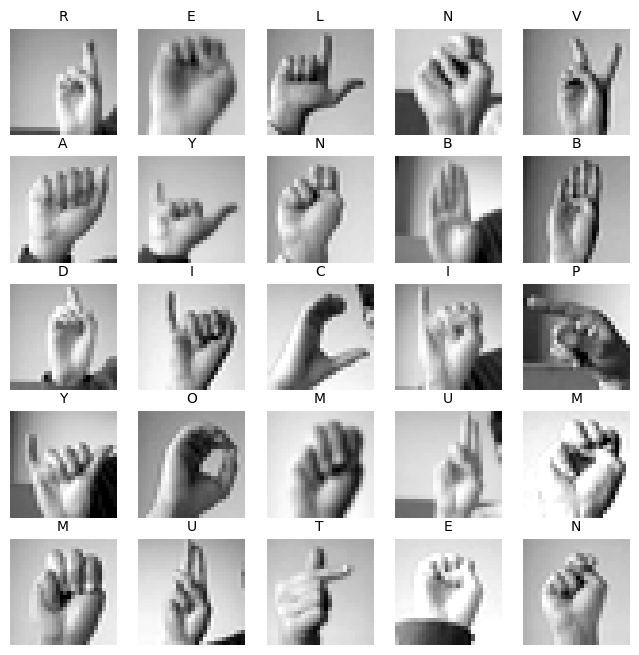

In [ ]:
# visualizing random images from the training set
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(8,8))
train_len = X_train.shape[0]

for ax in axs.reshape(-1):
    idx = np.random.randint(train_len)
    ax.set_title(label_map[y_train[idx]], size=10)
    ax.axis('off')
    ax.imshow(X_train[idx].reshape((28,28)), cmap='gray');

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


MACHINE LEARNING MODEL

In [ ]:
from sklearn.metrics import accuracy_score

models_data = {}

def model_fit_and_print_acc(model):
    start_train = timer()
    model.fit(X_train, y_train)
    end_train = timer()
    start_pred = timer()
    train_pred = model.predict(X_train)
    end_pred = timer()
    train_acc = accuracy_score(train_pred, y_train)
    print("Train accuracy: ", train_acc)
    test_pred = model.predict(X_test)
    test_acc = accuracy_score(test_pred, y_test)
    print("Test accuracy: ", test_acc)
    return [end_train-start_train, end_pred-start_pred, train_acc, test_acc]

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=10000)
models_data['Logistic Regression'] = model_fit_and_print_acc(log_reg)

Train accuracy:  1.0
Test accuracy:  0.6889291689905187


In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
models_data['Random Forest'] = model_fit_and_print_acc(forest_clf)


Train accuracy:  1.0
Test accuracy:  0.8218070273284998


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(5)
models_data['KNN'] = model_fit_and_print_acc(knn)

Train accuracy:  0.9988379082348227
Test accuracy:  0.8067484662576687


In [ ]:
#Function to plot the learning curves
def plot_results(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

    ax1.plot(history['loss'], label="Train loss")
    ax1.plot(history['val_loss'], label="Validation loss")
    ax2.plot(history['accuracy'], label="Train accuracy")
    ax2.plot(history['val_accuracy'], label="Validation accuracy")

    ax1.legend(fontsize=15);
    ax2.legend(fontsize=15);

    ax1.set_title('Loss per epoch', fontsize=25);
    ax1.set_xlabel("epoch", fontsize=20);
    ax2.set_title('Accuracy per epoch', fontsize=25);
    ax2.set_xlabel("epoch", fontsize=20);

    ax1.grid(True)
    ax2.grid(True);

In [ ]:
X_train = X_train.reshape((X_train.shape[0],28,28,1))
X_val = X_val.reshape((X_val.shape[0],28,28,1))
X_test = X_test.reshape((X_test.shape[0],28,28,1))
image_shape = X_train[0].shape

In [ ]:
model = tf.keras.Sequential([
    Input(shape=image_shape),
    RandomTranslation(0.15, 0.15),
    RandomZoom(0.15),
    RandomRotation(0.1),
    Conv2D(8, kernel_size=(3,3), strides=1, padding="same"),
    BatchNormalization(),
    ReLU(),
    Conv2D(8, kernel_size=(3,3), strides=1, padding="same"),
    BatchNormalization(),
    ReLU(),
    MaxPool2D(pool_size=2, strides=2, padding="valid"),
    Conv2D(16, kernel_size=(3,3), strides=1, padding="same"),
    BatchNormalization(),
    ReLU(),
    Conv2D(16, kernel_size=(3,3), strides=1, padding="same"),
    BatchNormalization(),
    ReLU(),
    MaxPool2D(pool_size=2, strides=2, padding="valid"),
    Conv2D(32, kernel_size=(3,3), strides=1, padding="same"),
    BatchNormalization(),
    ReLU(),
    Conv2D(32, kernel_size=(3,3), strides=1, padding="same"),
    BatchNormalization(),
    ReLU(),
    MaxPool2D(pool_size=2, strides=2, padding="valid"),
    Flatten(),
    Dense(100),
    Dropout(0.50),
    ReLU(),
    Dense(26, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_translation                   │ (None, 28, 28, 1)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 28, 28, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 28, 28, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 7, 32)            │             1

 Total params: 50,014 (195.37 KB)

 Trainable params: 49,790 (194.49 KB)

 Non-trainable params: 224 (896.00 B)

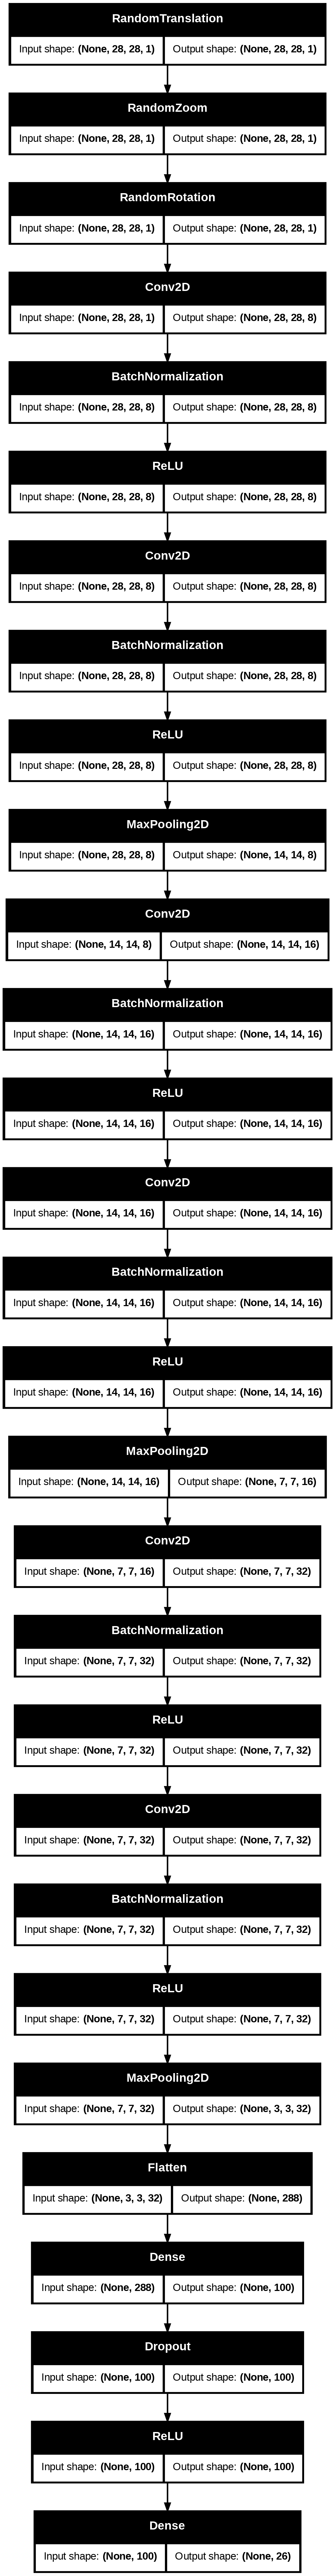

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0005), metrics=["accuracy"])

In [ ]:
batch_size = 32
start_train = timer()
history = model.fit(X_train, y_train, epochs=30, batch_size=batch_size, validation_data=(X_val, y_val))
end_train = timer()


Epoch 1/30
780/780 ━━━━━━━━━━━━━━━━━━━━ 66s 68ms/step - accuracy: 0.1121 - loss: 3.0818 - val_accuracy: 0.5084 - val_loss: 1.5386
Epoch 2/30
780/780 ━━━━━━━━━━━━━━━━━━━━ 78s 63ms/step - accuracy: 0.3565 - loss: 1.9846 - val_accuracy: 0.5540 - val_loss: 1.3756
Epoch 3/30
780/780 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - accuracy: 0.5227 - loss: 1.4186 - val_accuracy: 0.8092 - val_loss: 0.5869
Epoch 4/30
780/780 ━━━━━━━━━━━━━━━━━━━━ 81s 60ms/step - accuracy: 0.6192 - loss: 1.1214 - val_accuracy: 0.8336 - val_loss: 0.5064
Epoch 5/30
780/780 ━━━━━━━━━━━━━━━━━━━━ 92s 73ms/step - accuracy: 0.6791 - loss: 0.9206 - val_accuracy: 0.8152 - val_loss: 0.5404
Epoch 6/30
780/780 ━━━━━━━━━━━━━━━━━━━━ 74s 63ms/step - accuracy: 0.7267 - loss: 0.7923 - val_accuracy: 0.8868 - val_loss: 0.3258
Epoch 7/30
780/780 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - accuracy: 0.7624 - loss: 0.6800 - val_accuracy: 0.9104 - val_loss: 0.2541
Epoch 8/30
780/780 ━━━━━━━━━━━━━━━━━━━━ 81s 61ms/step - accuracy: 0.7894 - loss: 0.6102 - 

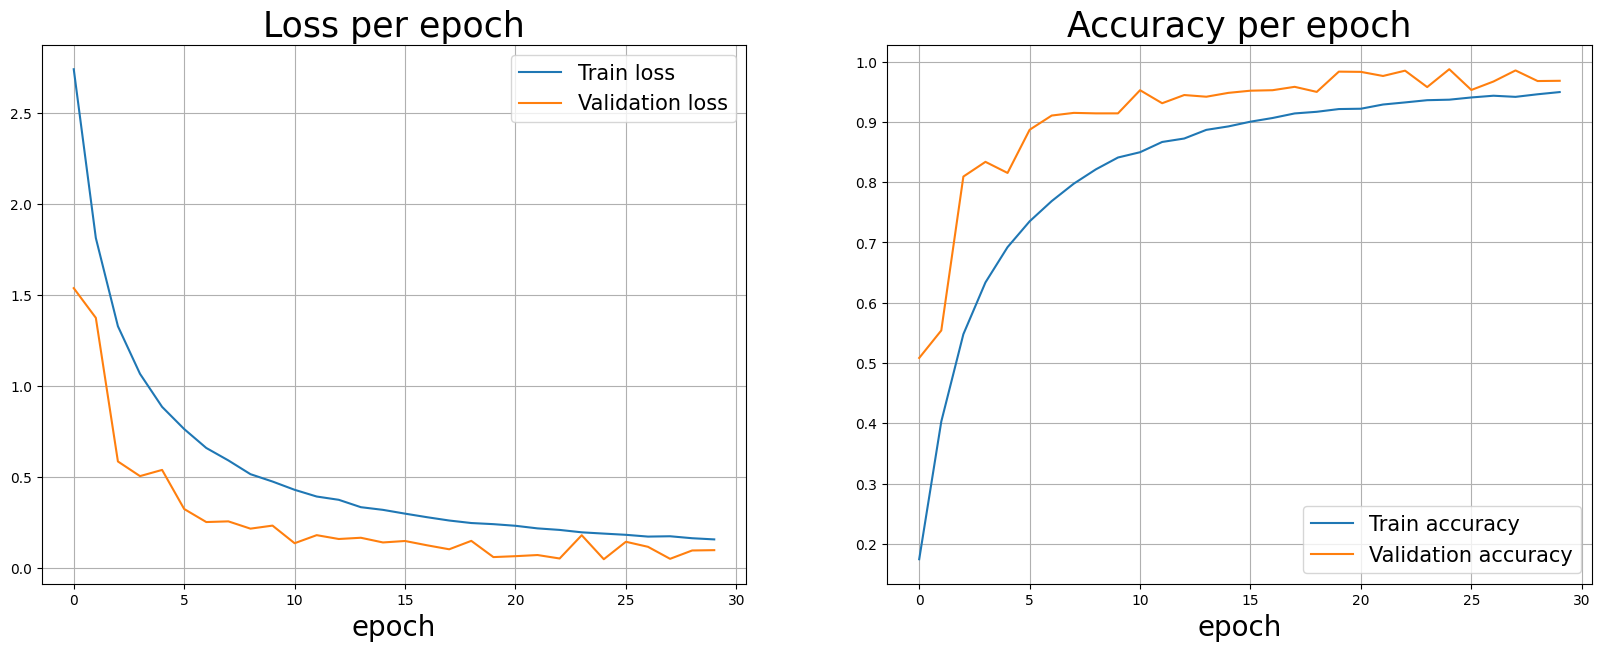

In [ ]:
plot_results(history.history)

In [ ]:
# CNN evaluation
start_pred = timer()
train_acc = model.evaluate(X_train, y_train)[1]
end_pred = timer()
test_acc = model.evaluate(X_test, y_test)[1]
models_data['CNN'] = [end_train-start_train, end_pred-start_pred, train_acc, test_acc]

780/780 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9675 - loss: 0.1053
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9499 - loss: 0.1415


In [ ]:
X_test.shape

(7172, 28, 28, 1)

In [ ]:
X_test[1]

array([[[-4.71296906e-01],
        [-5.14839828e-01],
        [-5.19846916e-01],
        [-5.58737695e-01],
        [-6.27484262e-01],
        [-6.79027200e-01],
        [-7.30250537e-01],
        [-8.16991329e-01],
        [-8.61591101e-01],
        [-8.85774970e-01],
        [-9.74817216e-01],
        [-1.03846538e+00],
        [-1.04304481e+00],
        [-1.09965456e+00],
        [-1.11128044e+00],
        [-1.24093854e+00],
        [-1.07705712e+00],
        [-1.17629254e+00],
        [-1.26051092e+00],
        [-1.19379258e+00],
        [-1.22842705e+00],
        [-1.16611946e+00],
        [-1.10245061e+00],
        [-1.03624964e+00],
        [-9.98119593e-01],
        [-8.93570364e-01],
        [-7.74993360e-01],
        [-7.99677730e-01]],

       [[-4.38245624e-01],
        [-4.57634687e-01],
        [-4.81724441e-01],
        [-5.28194249e-01],
        [-6.21729314e-01],
        [-6.41709089e-01],
        [-6.64863348e-01],
        [-7.50893712e-01],
        [-8.21214616e-01],

In [ ]:
test_pred = np.argmax(model.predict(X_test), axis=1)

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("Precision: ", precision_score(y_test, test_pred, average="micro").round(2))
print("Recall: ", recall_score(y_test, test_pred, average="micro").round(2))
print("F1 Score: ", f1_score(y_test, test_pred, average="micro").round(2))

Precision:  0.95
Recall:  0.95
F1 Score:  0.95


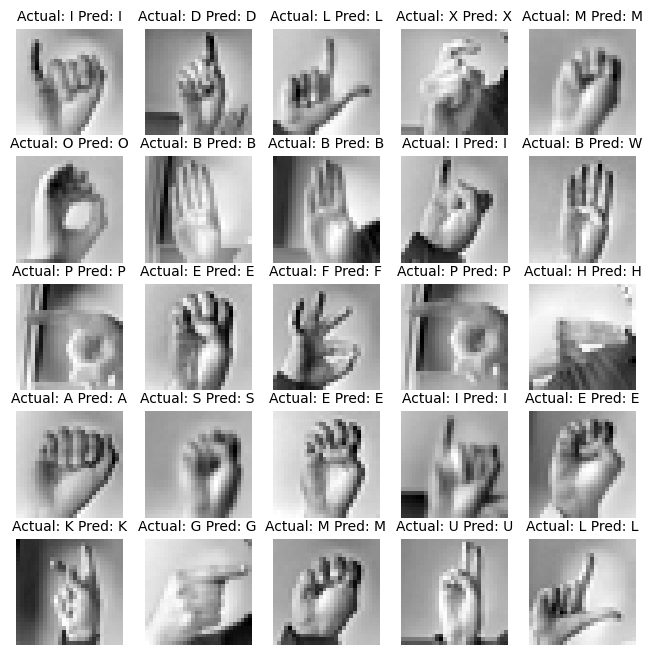

In [ ]:
# visualizing predictions of random images from the test set
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(8,8))
test_len = X_test.shape[0]

for ax in axs.reshape(-1):
    idx = np.random.randint(test_len)
    pred = test_pred[idx]
    ax.set_title("Actual: "+label_map[y_test[idx]]+" Pred: "+label_map[pred], size=10)
    ax.axis('off')
    ax.imshow(X_test[idx], cmap='gray');

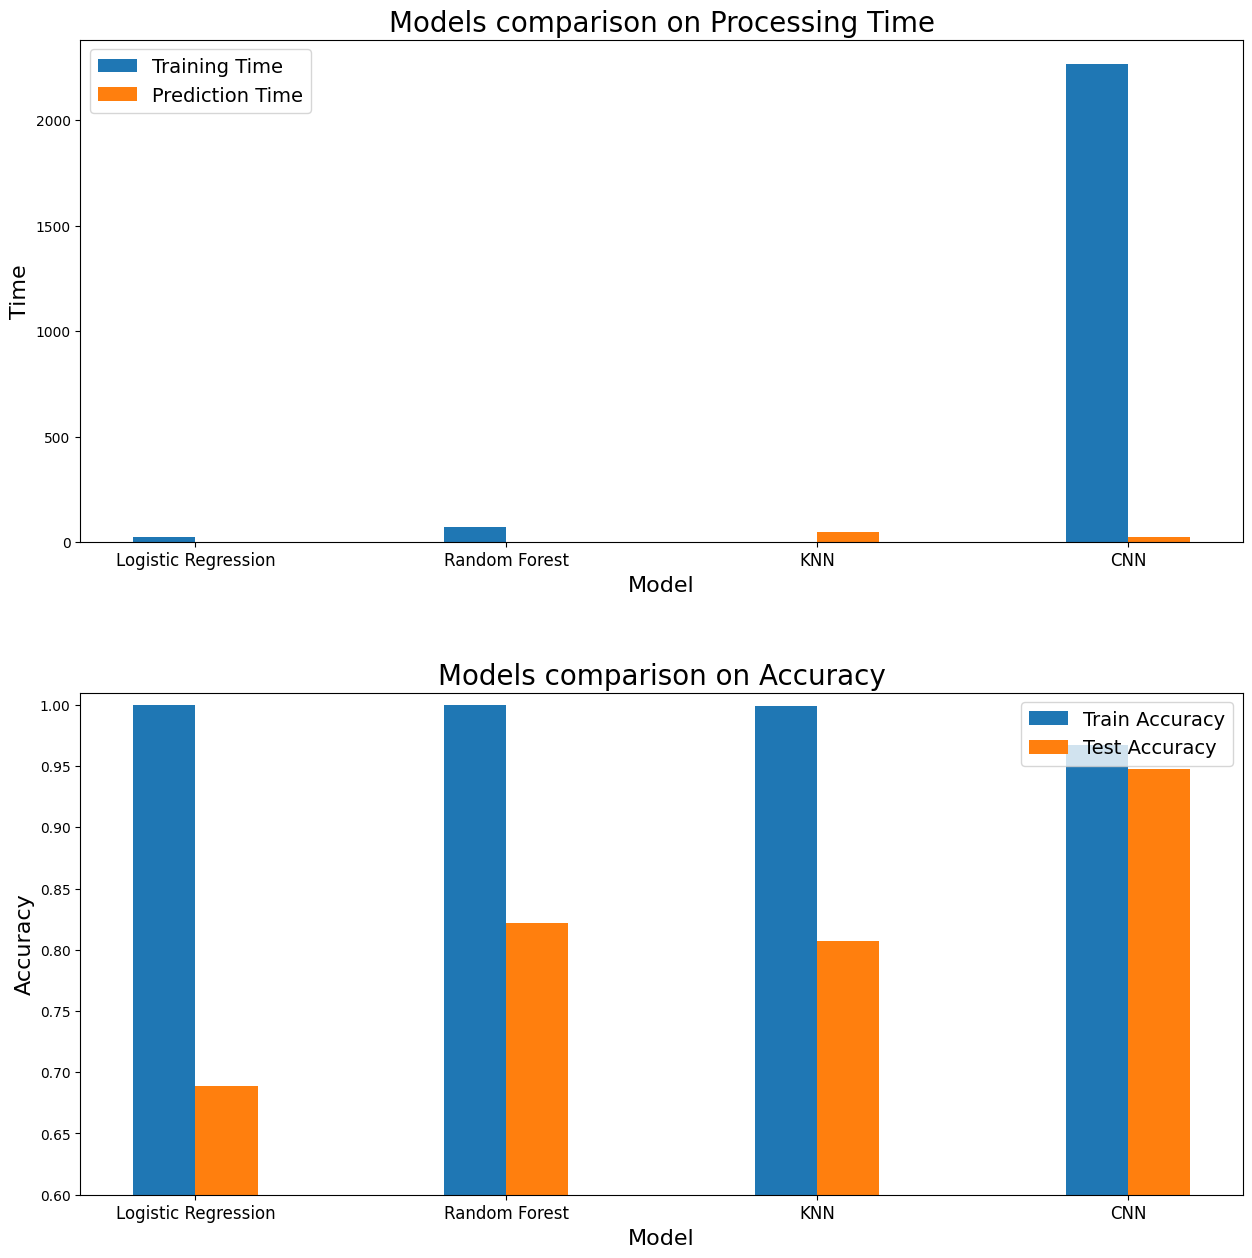

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
fig.subplots_adjust(hspace=0.3)

X = models_data.keys()
X_axis = np.arange(len(X))

ax1.bar(X_axis - 0.1, [value[0] for value in models_data.values()], 0.2, label = 'Training Time');
ax1.bar(X_axis + 0.1, [value[1] for value in models_data.values()], 0.2, label = 'Prediction Time');
ax1.set_xticks(X_axis, X, fontsize=12);
ax1.legend(fontsize=14);
ax1.set_xlabel("Model", fontsize=16)
ax1.set_ylabel("Time", fontsize=16);
ax1.set_title("Models comparison on Processing Time", fontsize=20)

ax2.bar(X_axis - 0.1, [value[2] for value in models_data.values()], 0.2, label = 'Train Accuracy');
ax2.bar(X_axis + 0.1, [value[3] for value in models_data.values()], 0.2, label = 'Test Accuracy');
ax2.set_xticks(X_axis, X, fontsize=12);
ax2.legend(fontsize=14);
ax2.set_xlabel("Model", fontsize=16)
ax2.set_ylabel("Accuracy", fontsize=16)
ax2.set_ylim((0.6, 1.01));
ax2.set_title("Models comparison on Accuracy", fontsize=20);


In [ ]:
testdf = pd.read_csv('/content/test1.csv')
testdf

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107


In [ ]:
testdfV = testdf.values[:,:].astype(np.float32())
testdfV1 = scaler.fit_transform(testdfV)

In [ ]:
testdfV1

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
testdf123 = testdfV1.reshape((testdfV1.shape[0],28,28,1))

In [ ]:
model.predict(testdf123)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


array([[0.03192263, 0.02042254, 0.02453886, 0.05349602, 0.02207319,
        0.02362402, 0.02140646, 0.02708025, 0.03031242, 0.00359501,
        0.08958857, 0.06369355, 0.03674316, 0.05011684, 0.0393039 ,
        0.03701432, 0.02805897, 0.05435853, 0.06925845, 0.02507122,
        0.04197102, 0.04426392, 0.03801418, 0.0854969 , 0.03468554,
        0.00388961]], dtype=float32)

In [ ]:
test_pred1 = np.argmax(model.predict(testdf123), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [ ]:
test_pred1

array([10])

In [ ]:
label_map[23]

'X'

In [ ]:
X_test.shape

(7172, 28, 28, 1)

In [ ]:
test_pred[6265]

15

In [ ]:
y_test[6265]

15

6265
766
1881
2971
2002
704
7137
1501
1223
2819
2217
5250
3998
422
3386
7041
2887
1515
3169
1394
1237
3322
4278
1666
4456


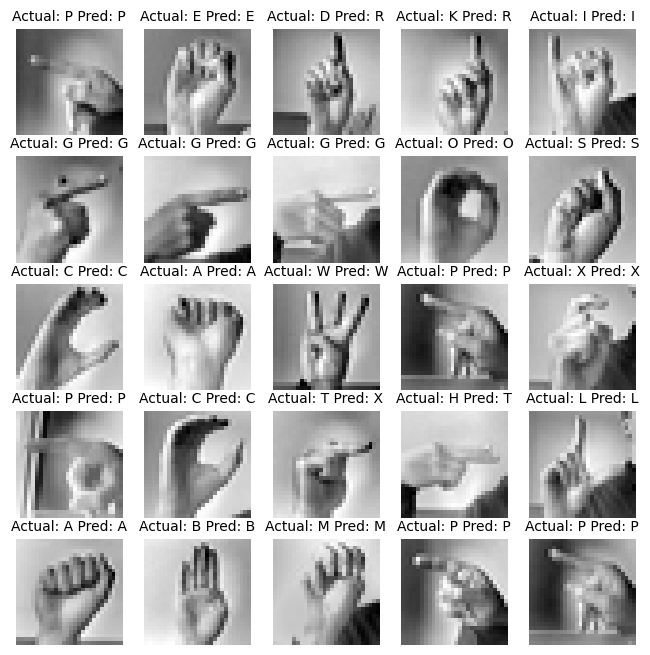

In [ ]:
# visualizing predictions of random images from the test set
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(8,8))
test_len = X_test.shape[0]

for ax in axs.reshape(-1):
    idx = np.random.randint(test_len)
    print(idx)
    pred = test_pred[idx]
    ax.set_title("Actual: "+label_map[y_test[idx]]+" Pred: "+label_map[pred], size=10)
    ax.axis('off')
    ax.imshow(X_test[idx], cmap='gray');

In [ ]:
label_map[7]

'H'